In [1]:
from utils import *

In [2]:
plt.rc('legend', frameon=False)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_style("white", rc=custom_params)
sns.set_palette("pastel")

## 2p Ca single analysis

### Logistic LOO context decoder

In [4]:
def loo_decode_context(ICRWL, smooth_place_maps):
    ctx_id = ICRWL['context']
    R_indices = ICRWL.index[ICRWL['reward_trial'] == True].tolist()
    NR_indices = ICRWL.index[ICRWL['reward_trial'] == False].tolist()
    
    # Features
    R_rasters = smooth_place_maps[:,R_indices,:]
    NR_rasters = smooth_place_maps[:,NR_indices,:]
    
    # Labels
    R_ctx_id = np.array(ctx_id[R_indices])
    NR_ctx_id = np.array(ctx_id[NR_indices])
    
    Accuracy_R = decode(R_rasters, R_ctx_id, type='Logistic')
    Accuracy_NR = decode(NR_rasters, NR_ctx_id, type='Logistic')
    
    return Accuracy_NR, Accuracy_R

In [5]:
results = []

for index, row in df_experiments.iterrows():
    print(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    
    # Lets read
    mouse = Mouse.from_database(
        trial_id=row['trial_id'],
        mouse_name=row['mouse_id'],
        expt_class=ImagingExperiment
    ) # returns df
    expt = mouse[0] # df
    bd_exp = expt.format_behavior_data() # dict
    # for key in bd_exp.keys(): print(key)
    
    # Get or Make ICRWL and place maps
    ICRWL = get_or_make_ICRWL(expt, bd_exp)
    place_maps, smooth_place_maps = get_or_make_place_maps(expt)
    

    # Get or Make Decoding
    Accuracy_NR, Accuracy_R = loo_decode_context(ICRWL, smooth_place_maps)
    res = {}
    res['mouse_id'] = row['mouse_id']
    res['trial_id'] = row['trial_id']
    res['area'] = row['area']
    res['Accuracy_NR'] = Accuracy_NR
    res['Accuracy_R'] = Accuracy_R
    res['neurons'] = smooth_place_maps.shape[0]
    res['laps'] = smooth_place_maps.shape[1]

    results.append(res)

Mouse: ek045, Trial ID: 34941, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek045, Trial ID: 34948, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek154, Trial ID: 37231, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek154, Trial ID: 37266, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek293, Trial ID: 40072, Area: CA3
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek293, Trial ID: 40161, Area: CA3
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%Mouse: ek339, Trial ID: 41169, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[=================== ] 99%

In [4]:
# pickle the results
# with open('single/decoding_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

with open('single/decoding_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [11]:

def plot_decoding_accuracy(results):
    plt.figure(figsize=(10,3))
    sns.lineplot(data=results["Accuracy_R"], label='Reward(A/B)')
    sns.lineplot(data=results["Accuracy_NR"], label='No Reward(C/D)')
    plt.title(f"Mouse: {results['mouse_id']}, Trial ID: {results['trial_id']}, Area: {results['area']}\nNeurons: {results['neurons']}, Laps: {results['laps']}")
    plt.xlabel("Bin#")
    plt.ylabel("Decoding Accuracy")
    plt.ylim(0,1.1)
    plt.tight_layout()
    plt.savefig(f"single/decoder/{results['mouse_id']}_{results['trial_id']}_acc.png", dpi=300)
    
for res in results:
    plot_decoding_accuracy(res)
    plt.close()

In [100]:
acc_df = pd.DataFrame(results)
print(acc_df)

  mouse_id  trial_id area                                        Accuracy_NR  \
0    ek045     34941  CA1  [0.4794520547945205, 0.4931506849315068, 0.506...   
1    ek045     34948  CA1  [0.4383561643835616, 0.4383561643835616, 0.452...   
2    ek154     37231  CA1  [0.0, 0.13157894736842105, 0.13157894736842105...   
3    ek154     37266  CA1  [0.4666666666666667, 0.5777777777777777, 0.6, ...   
4    ek293     40072  CA3  [0.611764705882353, 0.6588235294117647, 0.6941...   
5    ek293     40161  CA3  [0.8048780487804879, 0.8048780487804879, 0.804...   
6    ek339     41169  CA1  [0.7708333333333334, 0.7916666666666666, 0.812...   

                                          Accuracy_R  neurons  laps  
0  [0.5555555555555556, 0.5972222222222222, 0.611...      702   147  
1  [0.5342465753424658, 0.5616438356164384, 0.547...      693   148  
2  [0.0, 0.0, 0.0, 0.0, 0.05263157894736842, 0.10...       37    78  
3  [0.5777777777777777, 0.5555555555555556, 0.6, ...       34    91  
4  [0.535

In [54]:

# First, let's reshape the data for plotting with seaborn
plot_data_R = []
plot_data_NR = []

for idx, row in acc_df.iterrows():
    # For Reward trials (A/B contexts)
    for bin_idx, accuracy in enumerate(row['Accuracy_R']):
        plot_data_R.append({
            'mouse_id': row['mouse_id'],
            'trial_id': row['trial_id'],
            'area': row['area'],
            'bin': bin_idx,
            'accuracy': accuracy,
            'condition': 'Reward(A/B)'
        })
    
    # For No Reward trials (C/D contexts)
    for bin_idx, accuracy in enumerate(row['Accuracy_NR']):
        plot_data_NR.append({
            'mouse_id': row['mouse_id'],
            'trial_id': row['trial_id'],
            'area': row['area'],
            'bin': bin_idx,
            'accuracy': accuracy,
            'condition': 'No Reward(C/D)'
        })

# Convert to DataFrames
df_plot_R = pd.DataFrame(plot_data_R)
df_plot_NR = pd.DataFrame(plot_data_NR)

# Combine both datasets
df_plot_combined = pd.concat([df_plot_R, df_plot_NR], ignore_index=True)

,mouse_id,trial_id,area,bin,accuracy,condition
0,ek045,34941,CA1,0,0.555556,Reward(A/B)
1,ek045,34941,CA1,1,0.597222,Reward(A/B)
2,ek045,34941,CA1,2,0.611111,Reward(A/B)
3,ek045,34941,CA1,3,0.597222,Reward(A/B)
4,ek045,34941,CA1,4,0.583333,Reward(A/B)
...,...,...,...,...,...,...
1395,ek339,41169,CA1,95,1.000000,No Reward(C/D)
1396,ek339,41169,CA1,96,1.000000,No Reward(C/D)
1397,ek339,41169,CA1,97,0.979167,No Reward(C/D)
1398,ek339,41169,CA1,98,0.979167,No Reward(C/D)


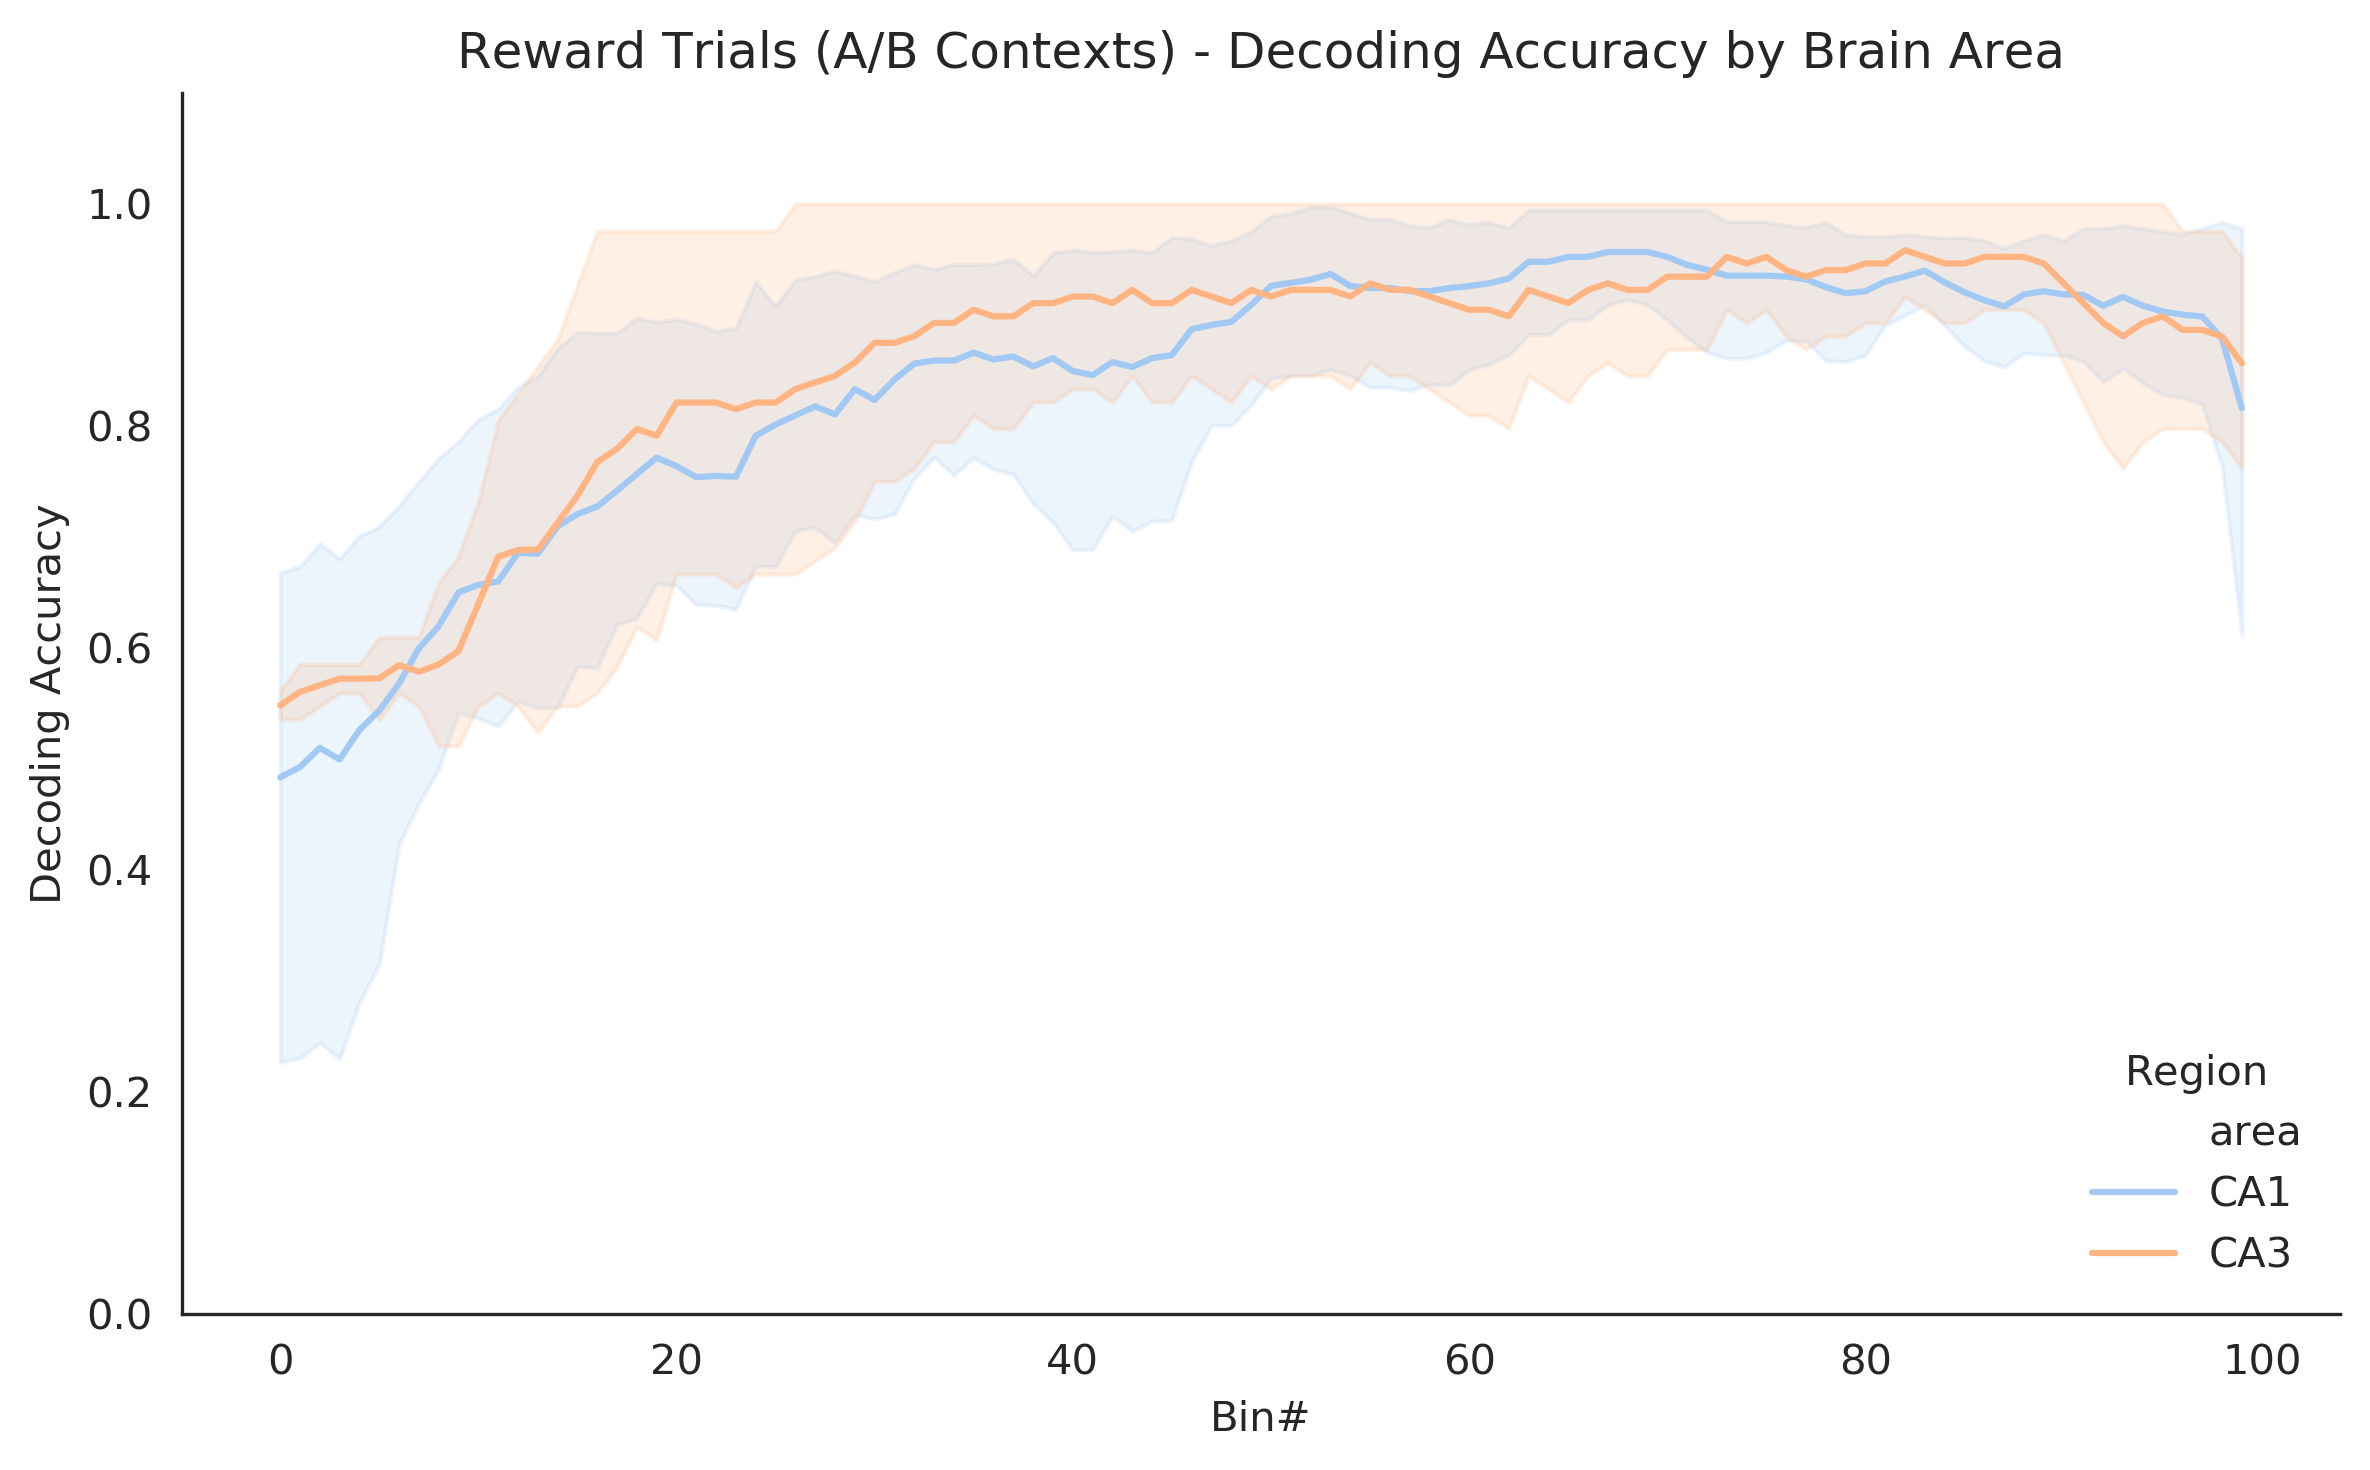

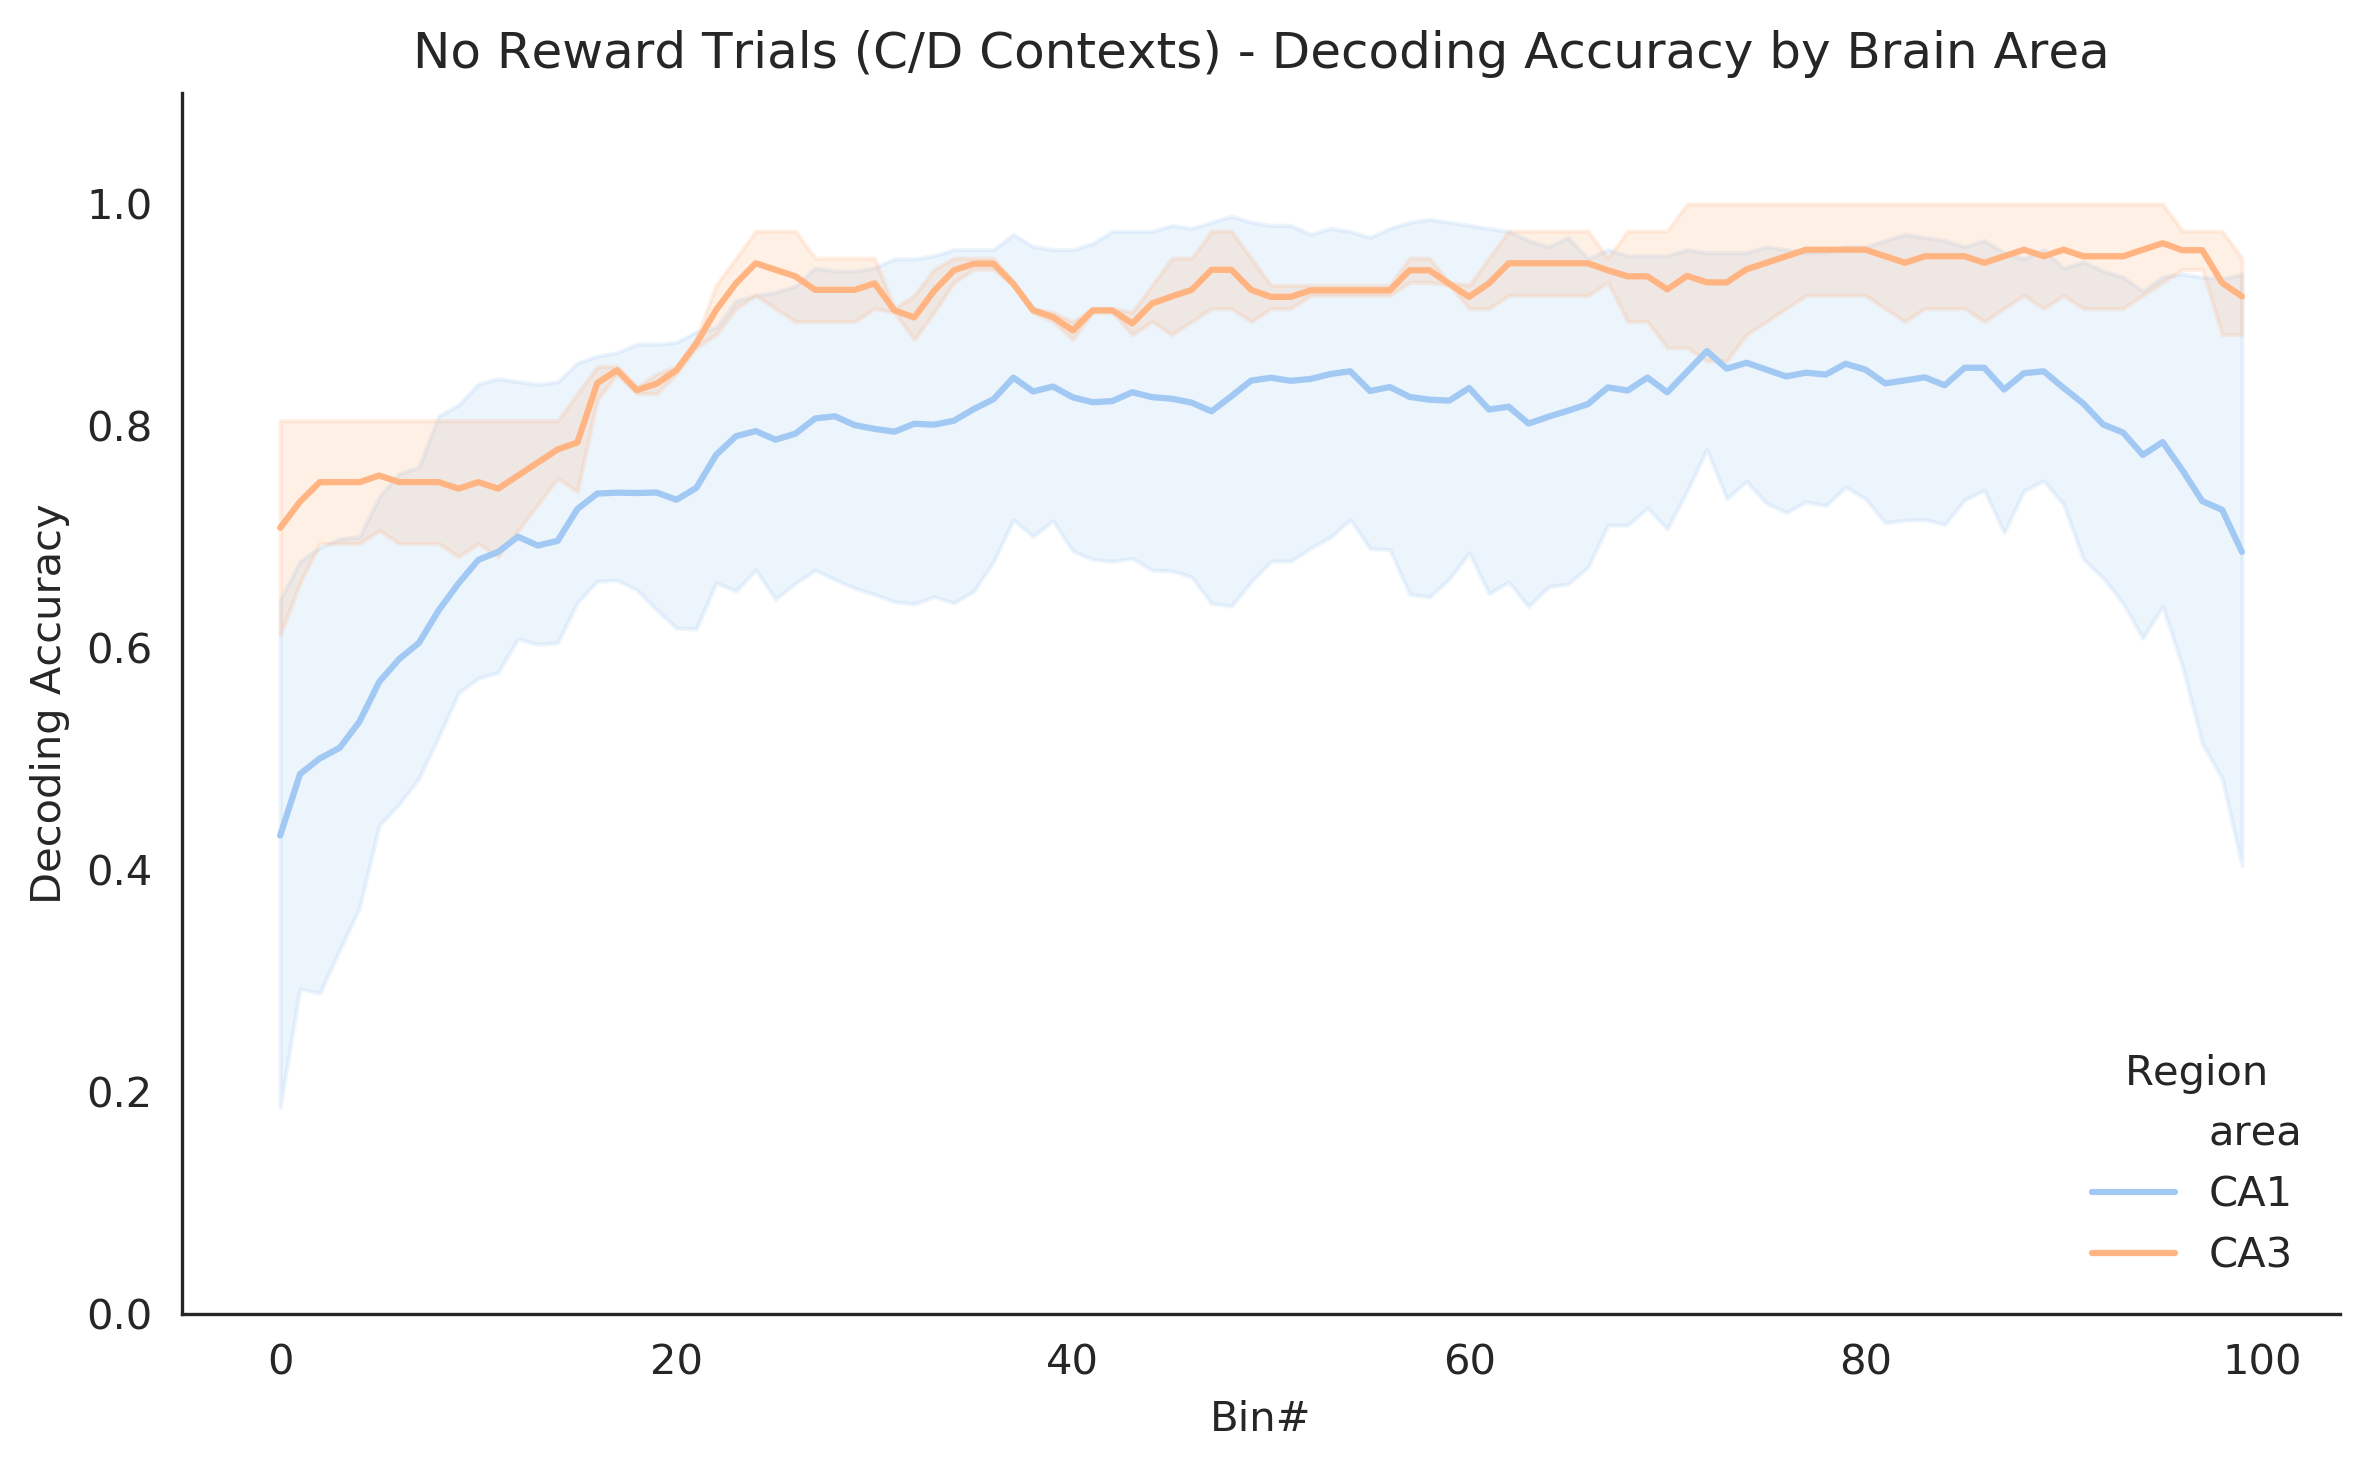

In [ ]:
# Plot 1: Reward trials (A/B contexts) by area
plt.figure(figsize=(8, 5), dpi=300)
sns.lineplot(data=df_plot_R, x='bin', y='accuracy', hue='area',  
             estimator='mean', err_style='band')
plt.xlabel("Bin#")
plt.ylabel("Decoding Accuracy")
plt.title("Reward Trials (A/B Contexts) - Decoding Accuracy by Brain Area")
plt.ylim(0, 1.1)
plt.legend(title='Region', loc="lower right")
plt.tight_layout()
plt.show()

# Plot 2: No Reward trials (C/D contexts) by area  
plt.figure(figsize=(8, 5), dpi=300)
sns.lineplot(data=df_plot_NR, x='bin', y='accuracy', hue='area', 
             estimator='mean', err_style='band')
plt.xlabel("Bin#")
plt.ylabel("Decoding Accuracy")
plt.title("No Reward Trials (C/D Contexts) - Decoding Accuracy by Brain Area")
plt.ylim(0, 1.1)
plt.legend(title='Region', loc="lower right")
plt.tight_layout()
plt.show()


### DI Discrimination index

In [3]:
from sklearn.metrics import auc

In [4]:
def get_auc(trace):
    """Compute Area Under the Curve (AUC) using the trapezoidal rule.
    Dimension of trace should be (lap_number,  n_position_bins); e.g. 30laps x 100bins. """
    AUC = []
    x=range(trace.shape[1])
    for lap_idx in range(trace.shape[0]):
        AUC.append(auc(x,trace[lap_idx,:]))
    return AUC

def get_DI(group1_trace,group2_trace):
    auc_group1 = get_auc(group1_trace)
    auc_group2 = get_auc(group2_trace)
    
    mean1 = np.mean(auc_group1)
    mean2 = np.mean(auc_group2)

    std1 = np.std(auc_group1)
    std2 = np.std(auc_group2)

    DI = (mean1-mean2)/np.math.sqrt((std1**2+std2**2)/2)
    return DI

def analyzeDI(rasters, ctx_id, num_shuffle=500):
    DI = []
    DI_signif = []
    num_shuffle = num_shuffle
    alpha = 0.05
    k = num_shuffle*alpha/2

    p = ProgressBar(rasters.shape[0])
    for n_idx in range(rasters.shape[0]):
        ctx_A_dfof = rasters[n_idx,np.where(ctx_id=='A')[0],:]
        ctx_B_dfof = rasters[n_idx,np.where(ctx_id=='B')[0],:]

        curr_DI = get_DI(ctx_A_dfof, ctx_B_dfof)
        DI.append(curr_DI)

        # shuffle_DI = []
        # for sfl_idx in range(num_shuffle):
        #     shuffle_rasters = np.take(rasters,(np.random.permutation(rasters.shape[1])),axis=1)

        #     ctx_A_dfof = shuffle_rasters[n_idx,np.where(ctx_id=='A')[0],:]
        #     ctx_B_dfof = shuffle_rasters[n_idx,np.where(ctx_id=='B')[0],:]
        #     shuffle_DI.append(get_DI(ctx_A_dfof, ctx_B_dfof))

        # # find significant DI value
        # R_tail = sorted(shuffle_DI)[-int(k)]
        # L_tail = sorted(shuffle_DI)[int(k)]

        # if curr_DI>=R_tail:
        #     DI_signif.append(1)
        # elif curr_DI <=L_tail:
        #     DI_signif.append(-1)
        # else: 
        #     DI_signif.append(0)
        p.update(n_idx)
    p.end()
    
    return DI, DI_signif

In [6]:
results = []

for index, row in df_experiments.iterrows():
    print(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    
    # Lets read
    mouse = Mouse.from_database(
        trial_id=row['trial_id'],
        mouse_name=row['mouse_id'],
        expt_class=ImagingExperiment
    ) # returns df
    expt = mouse[0] # df
    bd_exp = expt.format_behavior_data() # dict
    # for key in bd_exp.keys(): print(key)
    
    # Get or Make ICRWL and place maps
    ICRWL = get_or_make_ICRWL(expt, bd_exp)
    place_maps, smooth_place_maps = get_or_make_place_maps(expt)
    
    # make all true are A (go) and all false are B(no-go)
    ctx_id = np.array(['A' if rt else 'B' for rt in ICRWL['reward_trial'].values])
    DI, DI_signif = analyzeDI(smooth_place_maps, ctx_id, num_shuffle=200)
    
    
    res = {}
    res['mouse_id'] = row['mouse_id']
    res['trial_id'] = row['trial_id']
    res['area'] = row['area']
    res['DI'] = DI
    res['DI_signif'] = DI_signif
    res['neurons'] = smooth_place_maps.shape[0]
    res['laps'] = smooth_place_maps.shape[1]

    results.append(res)

Mouse: ek045, Trial ID: 34941, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek045, Trial ID: 34948, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek154, Trial ID: 37231, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek154, Trial ID: 37266, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek293, Trial ID: 40072, Area: CA3
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek293, Trial ID: 40161, Area: CA3
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%
Mouse: ek339, Trial ID: 41169, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
	[====================] 100%


In [ ]:
# pickle the results
# with open('single/DI_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

with open('single/DI_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [27]:
def plot_di_dist(res):
    plt.figure(figsize=(5, 3))
    plt.hist(res["DI"], bins=np.linspace(-1, 1, 20), density=False, alpha=0.7)
    plt.title("Distribution of DI")
    plt.xlabel("Active in No Reward <- DI -> Active in Reward")
    plt.ylabel("# of Neurons")
    plt.title(f"Mouse: {res['mouse_id']}, Trial ID: {res['trial_id']}, Area: {res['area']}")
    plt.tight_layout()
    file_name = f"single/DI/{res['mouse_id']}_{res['trial_id']}_di_dist.png"
    plt.savefig(file_name, dpi=300)
    plt.close()

for res in results:
    plot_di_dist(res)

### RSA

In [63]:
from scipy.spatial.distance import pdist, squareform

In [68]:
results = []

for index, row in df_experiments.iterrows():
    print(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    
    # Lets read
    mouse = Mouse.from_database(
        trial_id=row['trial_id'],
        mouse_name=row['mouse_id'],
        expt_class=ImagingExperiment
    ) # returns df
    expt = mouse[0] # df
    bd_exp = expt.format_behavior_data() # dict
    # for key in bd_exp.keys(): print(key)
    
    # Get or Make ICRWL and place maps
    ICRWL = get_or_make_ICRWL(expt, bd_exp)
    place_maps, smooth_place_maps = get_or_make_place_maps(expt)
    
    # Lets to representational similarity analysis
    ctx_id = ICRWL['context']
    
    # smooth_place_maps is neurons x laps x position_bins
    # ctx_id is ctxA, ctx_B, ctx_C, ctx_D
    # ctx_id labels the laps
    # lets make groups of ctxA/b/c/d with neurons x poisition_bins
    traces = smooth_place_maps.transpose(1, 0, 2)  # laps x neurons x position_bins
    traces = traces[:-1,:,:]  # remove last lap to make all equal
    ctxA = traces[np.where(ctx_id == 'ctxA')[0], :, :]
    ctxB = traces[np.where(ctx_id == 'ctxB')[0], :, :]
    ctxC = traces[np.where(ctx_id == 'ctxC')[0], :, :]
    ctxD = traces[np.where(ctx_id == 'ctxD')[0], :, :][:,:,:]  # make equal number of laps as others
    
    print(ctxA.shape, ctxB.shape, ctxC.shape, ctxD.shape)

    pairwise_distances = pdist(np.array([ctxA.flatten(), ctxB.flatten(), ctxC.flatten(), ctxD.flatten()]), metric='cosine')

    sq = squareform(pairwise_distances)
    
    # Sns heatmap the sqareform pairwise distances
    plt.figure(figsize=(5, 4))
    sns.heatmap(sq, xticklabels=['ctxA', 'ctxB', 'ctxC', 'ctxD'], yticklabels=['ctxA', 'ctxB', 'ctxC', 'ctxD'], annot=True, cmap='viridis')
    plt.title(f"Mouse: {row['mouse_id']}, Trial ID: {row['trial_id']}, Area: {row['area']}")
    plt.tight_layout()
    plt.savefig(f"single/RSA/{row['mouse_id']}_{row['trial_id']}_rsa.png", dpi=300)
    plt.close()

Mouse: ek045, Trial ID: 34941, Area: CA1
ICRWL.h5 is successfully loaded
place_maps.pkl is successfully loaded
(36, 702, 100) (36, 702, 100) (36, 702, 100) (37, 702, 100)


/home/rudra/anaconda/envs/lab3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


ValueError: A 2-dimensional array must be passed.

In [60]:
ctxA.shape, ctxB.shape, ctxC.shape, ctxD.shape

((36, 702, 100), (36, 702, 100), (36, 702, 100), (36, 702, 100))

In [ ]:
np.vstack